# 结果

## 原代码

- 学习率 0.0007

(batch_size = 8，二分类)


Training started:
Phase: train Epoch: 1/3 Loss: 0.6728 Acc: 0.5969             
Phase: val   Epoch: 1/3 Loss: 0.6394 Acc: *0.6645*             
Phase: train Epoch: 2/3 Loss: 0.6380 Acc: 0.6517             
Phase: val   Epoch: 2/3 Loss: 0.6128 Acc: *0.6740*             
Phase: train Epoch: 3/3 Loss: 0.6282 Acc: 0.6615             
Phase: val   Epoch: 3/3 Loss: 0.6066 Acc: *0.6890*          
Training completed in 40m 60s
Best test loss: 0.6066 | Best test accuracy: **0.6890**


- 学习率 0.01

(batch_size = 8，四分类)

Training started:
Phase: train Epoch: 1/3 Loss: 1.2628 Acc: 0.4150             
Phase: val   Epoch: 1/3 Loss: 1.2260 Acc: 0.4522             
Phase: train Epoch: 2/3 Loss: 1.2501 Acc: 0.4222             
Phase: val   Epoch: 2/3 Loss: 1.2367 Acc: 0.4375             
Phase: train Epoch: 3/3 Iter: 356/2501 Batch time: 0.6169


- 每个训练步骤的样本数 128

(step = 0.1，四分类)

Training started:
Phase: train Epoch: 1/3 Loss: 1.2495 Acc: 0.4289             
Phase: val   Epoch: 1/3 Loss: 1.2374 Acc: 0.4290         


- 每个训练步骤的样本数 128

(step = 0.1，十分类)

Training started:
Phase: train Epoch: 1/3 Loss: 2.1830 Acc: 0.1919             
Phase: val   Epoch: 1/3 Loss: 2.1894 Acc: 0.1853             
Phase: train Epoch: 2/3 Loss: 2.1674 Acc: 0.2010             
Phase: val   Epoch: 2/3 Loss: 2.1692 Acc: 0.2012

# Example 3: Hybrid transfer learning for image classification (CIFAR)

This is an example of a hybrid network for image classification, developed according to the *classical-to-quantum transfer learning* scheme presented in [1].

This notebook is inspired by the official PyTorch  [tutorial on transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) by Sasank Chilamkurthy [2].

The starting point is a convolutional neural network—ResNet18, introduced by Microsoft in 2016 [3]—which is pre-trained on the public ImageNet dataset. We replace the last fully connected layer with a *dressed quantum circuit* [1] that we train on a different dataset. 

Specifically, we focus on the following sub-classes of the CIFAR 10 dataset:
- Ref. [1], Example 3, dataset (a): *dogs* and *cats*.
- Ref. [1], Example 3, dataset (b): *planes* and *cars*.

The code can be easily modified to deal with different and/or more CIFAR classes.

## General setup
**Important:** this code makes use of the machine learning framework *PyTorch*, which is assumed to be correctly installed.

The main imported modules are: some common PyTorch libraries, the quantum 
software framework `pennylane` [4] and the python plotting library `matplotlib`.

In [1]:
# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Other tools
import time
import copy

env: OMP_NUM_THREADS=1


### Please choose and run only one of the following two cells, depending on the dataset of interest.

Settings to reproduce the results of ***Ref. [1], Example 3, dataset (a)***, i.e., _dogs_ vs. _cats_.

In [2]:
filtered_classes = ['cat', 'dog']  # Subset of CIFAR ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
n_qubits = 4                       # Number of qubits
quantum = True                     # If set to "False", the dressed quantum circuit is replaced by 
                                   # An enterily classical net (defined by the next parameter). 
classical_model = '512_n'          # Possible choices: '512_n','512_nq_n','551_512_n'. [nq=n_qubits, n=num_filtered_classes]
step = 0.001                       # Learning rate
batch_size = 8                     # Number of samples for each training step
num_epochs = 3                     # Number of training epochs
q_depth = 5                        # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 1             # Learning rate reduction applied every 10 epochs.                       
max_layers = 15                    # Keep 15 even if not all are used.
q_delta = 0.01                     # Initial spread of random quantum weights
rng_seed = 0                       # Seed for random number generator
start_time = time.time()           # start of the computation timer

Settings to reproduce the results of ***Ref. [1], Example 3, dataset (b)***, i.e., _planes_ vs. _cars_.

In [5]:
filtered_classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck'] # Subset of CIFAR ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
n_qubits = 4                        # Number of qubits
quantum = True                      # If set to "False", the dressed quantum circuit is replaced by 如果设置为 “False”，量子电路将被替换为 
                                    # An enterily classical net (defined by the next parameter).    一个简单的经典网络（由下一个参数定义）
classical_model = '512_n'           # Possible choices: '512_n','512_nq_n','551_512_n'. [nq=n_qubits, n=num_filtered_classes]  可能的选择
step = 0.1                         # Learning rate  学习率
batch_size = 128                      # Number of samples for each training step  每个训练步骤的样本数
num_epochs = 3                      # Number of training epochs  训练历元数
q_depth = 4                         # Depth of the quantum circuit (number of variational layers)  量子回路的深度（变异层数）
gamma_lr_scheduler = 0.1            # Learning rate reduction applied every 3 epochs. 每 3 个训练周期降低学习率               
max_layers = 15                     # Keep 15 ev en if not all are used.  即使没有全部使用，也要保留 15 层
q_delta = 0.01                      # Initial spread of random quantum weights  随机量子权重的初始分布
rng_seed = 0                        # Seed for random number generator  随机数发生器的种子
start_time = time.time()            # Start of the computation timer  计算开始计时器




Let us initialize a PennyLane with the default simulator.

In [6]:
dev = qml.device('default.qubit', wires=n_qubits)

Configure PyTorch to use CUDA, only if available. Otherwise simply use the CPU.

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Dataset loading

**Remark:** It may take several minutes to download the CIFAR dataset (only the first time).
The PyTorch packages `torchvision` and `torch.utils.data` are used for loading the dataset and performing standard preliminary image operations: resize, center, crop, normalize, *etc.* .

In [8]:
# Fixed pre-processing operations
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),     # uncomment for data augmentation
        #transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # Normalize input channels using mean values and standard deviations of ImageNet.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# =================== begin CIFAR dataset loading ===================
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_transforms['train'])
testset_full = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_transforms['val'])
image_datasets_full={'train': trainset_full, 'val': testset_full}

# CIFAR classes
class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Get indices of samples associated to filtered_classes
filtered_labels=[class_names.index(cl) for cl in filtered_classes]
sub_indices={'train': [], 'val': []}
for phase in ['train', 'val']:
    for idx, label in enumerate(image_datasets_full[phase].targets):  
        if label in filtered_labels:
            sub_indices[phase].append(idx)
            
# Initialize sub-datasets according to filtered indices
image_datasets = {x: torch.utils.data.Subset(image_datasets_full[x], sub_indices[x])
                for x in ['train', 'val']}

def labels_to_filtered(labels):
    """Maps CIFAR labels (0,1,2,3,4,5,6,7,8,9) to the index of filtered_labels"""
    return [filtered_labels.index(label) for label in labels]
# =================== end CIFAR dataset loading ==========================

# Number of samples
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Initialize dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Function to plot images from tensors
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # We apply the inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

Files already downloaded and verified
Files already downloaded and verified


Let us show a batch of the test data, just to have an idea of the classification problem.<br>
*Hint:* re-run the next cell to see more samples.

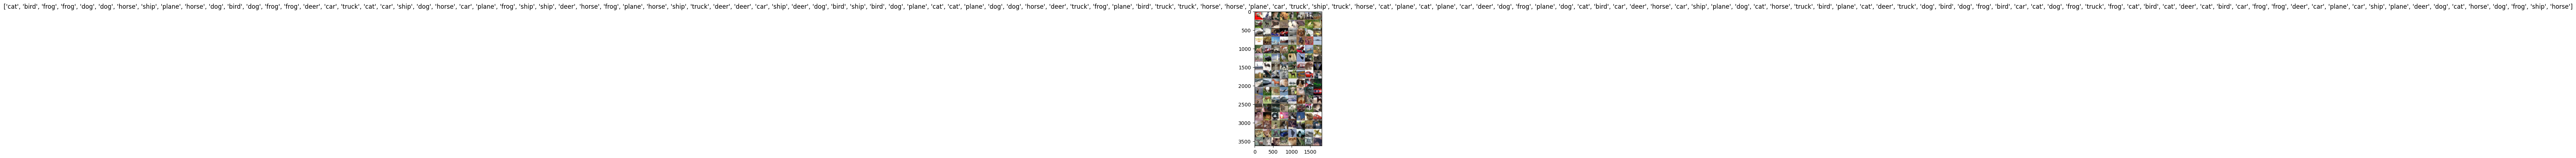

In [9]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In order to get reproducible results, we set a manual seed for the random number generator and re-initialize the dataloaders.

In [10]:
torch.manual_seed(rng_seed)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

## Hybrid transfer learning model (classical-to-quantum).

We first define some quantum layers that will compose the quantum circuit.

In [11]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates. 
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis. 
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT  
    for i in range(0, nqubits - 1, 2): # Loop over even indices: i=0,2,...N-2  
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1,2): # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

Let us define the quantum circuit by using the PennyLane `qnode` decorator . The structure is that of a typical variational quantum circuit:
1. All qubits are first initialized in a balanced superposition of *up* and *down* states, then they are rotated according to the input parameters (local embedding);
2. Successively a sequence of trainable rotation layers and constant entangling layers is applied. This block is responsible for the main computation necessary to solve the classification problem.
3. Eventually, for each qubit, the local expectation value of the Z operator is measured. This produces a classical output vector, suitable for additional post-processing.

In [12]:
@qml.qnode(dev, interface='torch')
def q_net(q_in, q_weights_flat):
        
        # Reshape weights
        q_weights = q_weights_flat.reshape(max_layers, n_qubits)
        
        # Start from state |+> , unbiased w.r.t. |0> and |1>
        H_layer(n_qubits)
        
        # Embed features in the quantum node
        RY_layer(q_in)
       
        # Sequence of trainable variational layers
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k+1])

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

We can now define a custom `torch.nn.Module` representing a *dressed* quantum circuit.<br>
This is a concatenation of:
1. A classical pre-processing layer (`nn.Linear`)
2. A classical activation function (`F.tanh`)
3. A constant `np.pi/2.0` scaling factor.
2. The previously defined quantum circuit (`q_net`)
2. A classical post-processing layer (`nn.Linear`)

The input of the module is a batch of vectors with 512 real parameters (features) and the output is a batch of vectors with *n* real outputs (one for each class of images).

In [13]:
class Quantumnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.pre_net = nn.Linear(512, n_qubits)
            self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
            self.post_net = nn.Linear(n_qubits, len(filtered_classes))

        def forward(self, input_features):
            pre_out = self.pre_net(input_features) 
            q_in = torch.tanh(pre_out) * np.pi / 2.0   
            
            # Apply the quantum circuit to each element of the batch, and append to q_out
            q_out = torch.Tensor(0, n_qubits)
            q_out = q_out.to(device)
            for elem in q_in:
                # q_out_elem = q_net(elem,self.q_params).float().unsqueeze(0)
                q_out_elem = torch.Tensor(q_net(elem,self.q_params)).float().unsqueeze(0)
                q_out = torch.cat((q_out, q_out_elem))
            return self.post_net(q_out)

We are finally ready to build our full hybrid classical-quantum network. We follow the *transfer learning* approach:
1. First load the classical pre-trained network *ResNet18* from the `torchvision.models` zoo.<br> **Important:** the model is downloaded from Internet and it may take a long time (only the first time). 
2. Freeze all the weights since they should not be trained.
3. Replace the last fully connected layer with our trainable dressed quantum circuit (`Quantumnet`). Alternatively, if `quantum==False`, an entirely classical analogue is used.

In [15]:
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False

if quantum:
    model_hybrid.fc = Quantumnet()

elif classical_model == '512_n':
    model_hybrid.fc = nn.Linear(512,len(filtered_classes))

elif classical_model == '512_nq_n':
    model_hybrid.fc = nn.Sequential(nn.Linear(512, n_qubits),torch.nn.ReLU(),nn.Linear(n_qubits, len(filtered_classes))) 

elif classical_model == '551_512_n':
    model_hybrid.fc = nn.Sequential(nn.Linear(512, 512), torch.nn.ReLU(), nn.Linear(512, len(filtered_classes)))

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)
print('over')

over


## Training and results
Before training the network we need to specify the *loss* function. We use the *relative entropy* as objective function.

In [16]:
criterion = nn.CrossEntropyLoss()

We also initialize the *optimizer* which is called at each training step in order to update the weights of the model.

In [17]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

We schedule to reduce the learning rate by a factor of `gamma_lr_scheduler` every epoch.

In [18]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=3, gamma=gamma_lr_scheduler)

What follows is a training function that will be called later. This function should return a trained model that can be used to make predictions (classifications). 

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
        since = time.time()
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        best_loss = 10000.0   # Large arbitrary number
        best_acc_train = 0.0
        best_loss_train = 10000.0  # Large arbitrary number
        print('Training started:')
        for epoch in range(num_epochs):
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    # Set model to training mode
                    scheduler.step()
                    model.train() 
                else:
                    # Set model to evaluate mode
                    model.eval()   
                
                # Iteration loop
                running_loss = 0.0
                running_corrects = 0
                n_batches = dataset_sizes[phase] // batch_size
                it = 0
                for inputs, cifar_labels in dataloaders[phase]:
                    since_batch = time.time()
                    batch_size_ = len(inputs)
                    inputs = inputs.to(device)
                    labels = torch.tensor(labels_to_filtered(cifar_labels))
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    
                    # Track/compute gradient and make an optimization step only when training
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            
                    # Print iteration results
                    running_loss += loss.item() * batch_size_
                    batch_corrects = torch.sum(preds == labels.data).item()
                    running_corrects += batch_corrects
                    print('Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}'.format(phase, epoch + 1, num_epochs, it + 1, n_batches + 1, time.time() - since_batch), end='\r', flush=True)
                    it += 1
                
                # Print epoch results
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]
                print('Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}             '.format('train' if phase == 'train' else 'val  ', epoch + 1, num_epochs, epoch_loss, epoch_acc))
                
                # Check if this is the best model wrt previous epochs
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                if phase == 'train' and epoch_acc > best_acc_train:
                    best_acc_train = epoch_acc
                if phase == 'train' and epoch_loss < best_loss_train:
                    best_loss_train = epoch_loss
        
        # Print final results             
        model.load_state_dict(best_model_wts)
        time_elapsed = time.time() - since
        print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best test loss: {:.4f} | Best test accuracy: {:.4f}'.format(best_loss, best_acc))
        return model



print('over')

over


We are ready perform the actual training process.

In [ ]:
model_hybrid = train_model(model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs)

Training started:
Phase: train Epoch: 1/3 Loss: 2.1830 Acc: 0.1919             
Phase: val   Epoch: 1/3 Loss: 2.1894 Acc: 0.1853             
Phase: train Epoch: 2/3 Loss: 2.1674 Acc: 0.2010             
Phase: val   Epoch: 2/3 Loss: 2.1692 Acc: 0.2012             


In [71]:
print(lr)

NameError: name 'lr' is not defined

We save the optimal weights that achieved the best accuracy into a PyTorch file that will be created in the current working directory. In this way, the saved weights can be loaded in the future without training again.

**Important: Be aware that running next cell will overwrite a previously saved file. So, we suggest to run the next cell only after a good training process.**

In [27]:
if quantum:
        torch.save(model_hybrid.state_dict(), 
            'quantum_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'
        )
else:
        torch.save(model_hybrid.state_dict(), 
            'classical_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'
        )
print("Model state_dict saved.")

Model state_dict saved.


## Load model from file
To load the pre-trained weights it is necessary to first define the model. So, before this cell, one should have run all the cells above the *[Training and results](##Training_and_results)* section.

In [28]:
if quantum:
    model_hybrid.load_state_dict(torch.load(
        'quantum_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'
        )
    )
                                 
else:
    model_hybrid.load_state_dict(torch.load(
        'classical_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'
        )
    )

We apply the model to the test dataset to compute the associated *loss* and *accuracy*.

In [29]:
criterion = nn.CrossEntropyLoss()
running_loss = 0.0
running_corrects = 0
n_batches = dataset_sizes['val'] // batch_size
it = 0
model_hybrid.eval()

# Testing loop
for inputs, cifar_labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = torch.tensor(labels_to_filtered(cifar_labels))
    labels = labels.to(device)
    batch_size_ = len(inputs)
    with torch.set_grad_enabled(False):
        outputs = model_hybrid(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    running_loss += loss.item() * batch_size_
    batch_corrects = torch.sum(preds == labels.data).item()
    running_corrects += batch_corrects
    print('Iter: {}/{}'.format(it+1,n_batches+1), end='\r', flush=True)
    it += 1
                    
# Print final results
epoch_loss = running_loss / dataset_sizes['val']
epoch_acc = running_corrects / dataset_sizes['val']
print('\nTest Loss: {:.4f} Test Acc: {:.4f}        '.format(epoch_loss, epoch_acc))

Iter: 250/251
Test Loss: 0.6066 Test Acc: 0.6890        


## Visualize the model
Let us compute and the visualize the predictions for a batch of test data.
*Hint:* re-run the next cell to see more samples.

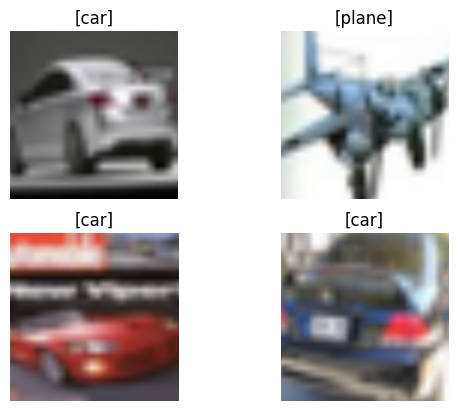

In [31]:
def visualize_model(model, num_images=6, fig_name='Predictions'):
    images_so_far = 0
    fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for i, (inputs, cifar_labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = torch.tensor(labels_to_filtered(cifar_labels))
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('[{}]'.format(filtered_classes[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return
        
visualize_model(model_hybrid, num_images=4)


## References

[1] Andrea Mari, Thomas R. Bromley, Josh Izaac, Maria Schuld, and Nathan Killoran. _Transfer learning in hybrid classical-quantum neural networks_. [arXiv:1912.08278](https://arxiv.org/abs/1912.08278), (2019).

[2] Sasank Chilamkurthy. PyTorch transfer learning tutorial. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html.

[3] Kaiming He, Xiangyu Zhang, Shaoqing ren and Jian Sun. _Deep residual learning for image recognition_.
  Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, 770-778 (2016). [DOI: 10.1109/CVPR.2016.90]( https://doi.org/10.1109/CVPR.2016.90).
  
[4] Ville Bergholm, Josh Izaac, Maria Schuld, Christian Gogolin, Carsten Blank, Keri McKiernan, and Nathan Killoran. PennyLane: Automatic differentiation of hybrid quantum-classical computations. [arXiv:1811.04968](https://arxiv.org/abs/1811.04968), (2018).